In [ ]:
%%capture
!pip install tensorflow.keras
!pip install tensorflow-datasets
!pip install tensorflow_data_validation

In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.efficientnet import EfficientNetB5
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.metrics import Recall,Precision

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


# PARÁMETROS


In [ ]:
batch_size = 4
epochs = 50
lr = 0.0001
#device = #este se pone en tensorflow también?
image_size = (150,150)



In [ ]:

(train_ds, validation_ds, test_ds), info = tfds.load("colorectal_histology",
                                                     split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
                                                     as_supervised=True,  #returns (input,label)
                                                     with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
print(info.features["label"].num_classes)
print(info.features["label"].names)
print(info.features["label"].int2str(7))  # Human readable version (8 -> 'cat')
print(info.features["label"].str2int('tumor'))

8
['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa', 'adipose', 'empty']
empty
0


In [ ]:
# Obtener nombres de las clases y asegurarse de que comiencen con mayúscula
class_names = [name.capitalize() for name in info.features['label'].names]

def get_example_per_class(dataset, num_classes):
    examples = {}
    for image, label in dataset:
        label = label.numpy()
        if label not in examples:  # Tomar solo un ejemplo por clase
            examples[label] = image
        if len(examples) == num_classes:  # Cuando ya tenemos un ejemplo por clase, detener
            break
    return examples

# Obtener un ejemplo de cada clase del conjunto de entrenamiento
num_classes = info.features['label'].num_classes
examples = get_example_per_class(train_ds, num_classes)

# Graficar los ejemplos en 2 filas y 4 columnas
plt.figure(figsize=(12, 6))
columns = 4
rows = 2

for idx, (label, image) in enumerate(examples.items()):
    plt.subplot(rows, columns, idx + 1)
    plt.imshow(image.numpy().squeeze(), cmap='gray')  # Mostrar imagen
    plt.title(class_names[label])  # Título con nombre de clase en mayúscula
    plt.axis('off')

plt.tight_layout()  # Ajustar diseño
plt.show()
plt.show()

In [ ]:
tfds.show_examples(train_ds, info)

In [ ]:
#resize the image. It is done to check if all images have the same size
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, image_size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, image_size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, image_size), y))


#Load in memory in the first epoch (CAREFUL IF NOT ENOUGH RAM)
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=5)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=5)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=5)

In [ ]:

#Aply data augmentation to the dataset
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
], name ="data_augmentation")

In [ ]:
input_shape = image_size + (3,)

# VGG19 TRANSFER LEARNING


VER COMO CAMBIA EL MODELO SI SE CONGELAN LAS CAPAS O SI NO, Y SI INCLUIR SUS TRES FCL AL PRINCIPIO O NO (INCLUDE TOP=TRUE)
MIRAR METRICAS DE KERAS
MIRAR MEJOR LOSS PARA CLASIFICACION MULTICLASE


https://www.kaggle.com/code/givkashi/transfer-learning-vgg19
https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG19
https://keras.io/api/metrics/

https://github.com/BehshadR/Colorectal-Cancer-Histology-Transfer-Learning-and-Fine-Tuning/blob/main/Colorectal_Cancer_Histology_Transfer_Learning_and_Fine_Tuning.ipynb

In [ ]:

model_base_VGG19 = VGG19(input_shape=input_shape,
                         include_top=False,
                         weights="imagenet")

model_base_VGG19.trainable = False  #freeze the trainable layers of the base model

inputs = tf.keras.Input(shape=input_shape, name = 'input_layer')
x = data_augmentation(inputs)
x = tf.keras.layers.Rescaling(1./127.5 , offset=-1)(x)  #rescale to [-1,1]
x = model_base_VGG19(x, training=False) #cause it's fine tunning, we don't want batch-norm statistics to be updated
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation='relu')(x)
x= tf.keras.layers.Dense(2000, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      33,558,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2000)                │       8,194,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         512,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,291,224 (237.62 MB)

 Trainable params: 42,266,840 (161.24 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
model_base_VGG19.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

# VGG19 FINE TUNNING

In [ ]:
model_base_VGG19.trainable = True

for layer in model_base_VGG19.layers[:-10]:    #freez all layer excepto the last 10 layers
  layer.trainable = False

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      33,558,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2000)                │       8,194,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         512,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 146,824,906 (560.09 MB)

 Trainable params: 59,965,656 (228.75 MB)

 Non-trainable params: 2,325,568 (8.87 MB)

 Optimizer params: 84,533,682 (322.47 MB)

# EFFICIENTNET TRANSFER LEARNING

In [ ]:
model_base_B5 = EfficientNetB5(input_shape=input_shape,
                         include_top=False,
                         weights="imagenet")

model_base_B5.trainable = False  #freeze the trainable layers of the base model

inputs = tf.keras.Input(shape=input_shape, name = 'input_layer')
x = data_augmentation(inputs)
x = tf.keras.layers.Rescaling(1./255)(x)  #rescale to [0,1]
x = model_base_B5(x, training=False) #cause it's transfer learning, we don't want batch-norm statistics to be updated
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_54 (Rescaling)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb5 (Functional)          │ (None, 5, 5, 2048)          │      28,513,527 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,861,823 (209.28 MB)

 Trainable params: 26,348,296 (100.51 MB)

 Non-trainable params: 28,513,527 (108.77 MB)

In [ ]:
model_base_B5.summary()

# EFFICIENTNET FINE TUNNNING

In [ ]:
model_base_B5.trainable = True

for layer in model_base_B5.layers[:-10]:    #freez all layer excepto the last 10 layers
  layer.trainable = False

model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_54 (Rescaling)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb5 (Functional)          │ (None, 5, 5, 2048)          │      28,513,527 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 107,558,417 (410.30 MB)

 Trainable params: 29,764,488 (113.54 MB)

 Non-trainable params: 25,097,335 (95.74 MB)

 Optimizer params: 52,696,594 (201.02 MB)

# INCEPTIONV3

In [ ]:
model_base_Inception = InceptionV3(input_shape=input_shape,
                         include_top=False,
                         weights="imagenet")

model_base_Inception.trainable = False  #freeze the trainable layers of the base model

inputs = tf.keras.Input(shape=input_shape, name = 'input_layer')
x = data_augmentation(inputs)
x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(x)  #rescale to [-1,1]
x = model_base_Inception(x, training=False) #cause it's transfer learning, we don't want batch-norm statistics to be updated
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5, name="dropout_1")(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

In [ ]:
model_base_Inception.summary()

# INCEPTIONV3 FINE TUNNING

In [ ]:
model_base_Inception.trainable = True

for layer in model_base_Inception.layers[:-40]:    #freez all layer except the last 40 layers
  layer.trainable = False

model.summary()

# RESNET50 TRANSFER LEARNING

In [ ]:
model_base_ResNet50v2 = ResNet50V2(input_shape=input_shape,
                         include_top=False,
                         weights="imagenet")

model_base_ResNet50v2.trainable = False  #freeze the trainable layers of the base model

inputs = tf.keras.Input(shape=input_shape, name = 'input_layer')
x = data_augmentation(inputs)
x = tf.keras.layers.Rescaling(1./127.5 , offset=-1)(x)  #rescale to [-1,1]
x = model_base_ResNet50v2(x, training=False) #cause it's fine tunning, we don't want batch-norm statistics to be updated
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 5, 5, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,913,096 (190.40 MB)

 Trainable params: 26,348,296 (100.51 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

# RESNET50 FINE TUNNING

In [ ]:
model_base_ResNet50v2.trainable = True

for layer in model_base_ResNet50v2.layers[:-140]:    #freez all layer except the last 140 layers
  layer.trainable = False

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 5, 5, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,609,690 (391.42 MB)

 Trainable params: 49,329,416 (188.18 MB)

 Non-trainable params: 583,680 (2.23 MB)

 Optimizer params: 52,696,594 (201.02 MB)

# ENTRENAR MODELO TRANSFER

In [ ]:

optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=optimizer)

In [ ]:
filepath = 'best_weights.weights.h5'


red_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.02,
                                              patience = 10,
                                              verbose=1,
                                              min_lr=1e-7)

earlystopping = EarlyStopping(monitor = 'val_loss',
                              mode = 'auto' ,
                              patience = 15,
                              verbose = 1)

checkpoint = ModelCheckpoint(filepath,
                            monitor = 'val_loss',
                            mode='auto',
                            save_best_only=True,
                            save_weights_only=True,
                            verbose = 1)


callback_list = [earlystopping, checkpoint, red_lr]

In [ ]:
model_history = model.fit(train_ds,
                          validation_data= validation_ds,
                          epochs = 50,
                          callbacks = callback_list,
                          verbose = 1
                          )

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7129 - loss: 0.9768
Epoch 1: val_loss improved from inf to 0.49361, saving model to best_weights.weights.h5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 60s 47ms/step - accuracy: 0.7129 - loss: 0.9765 - val_accuracy: 0.8540 - val_loss: 0.4936 - learning_rate: 1.0000e-04
Epoch 2/50
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8352 - loss: 0.4841
Epoch 2: val_loss improved from 0.49361 to 0.43316, saving model to best_weights.weights.h5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.8353 - loss: 0.4841 - val_accuracy: 0.8640 - val_loss: 0.4332 - learning_rate: 1.0000e-04
Epoch 3/50
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8565 - loss: 0.4231
Epoch 3: val_loss improved from 0.43316 to 0.41122, saving model to best_weights.weights.h5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.8565 - loss: 0.4231 - val_accuracy: 0.8600 - val_loss: 0.4112 - learning_rate: 1.0000e-04
Epoch 4/50
 99

# ENTRENAR MODELO TUNNING

In [ ]:
filepath = 'best_weights_tunning.weights.h5'

#reduction of the lr as a callback (https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau)

red_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.02,
                                              patience = 10,
                                              verbose=1,
                                              min_lr=1e-7)

earlystopping = EarlyStopping(monitor = 'val_loss',
                              mode = 'auto' ,
                              patience = 15,
                              verbose = 1)

checkpoint = ModelCheckpoint(filepath,
                            monitor = 'val_loss',
                            mode='auto',
                            save_best_only=True,
                            save_weights_only=True,
                            verbose = 1)

callback_list = [earlystopping, checkpoint, red_lr]

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=optimizer)

model_hisotry_fine = model.fit(train_ds,
                               epochs = 50,
                               validation_data = validation_ds,
                               callbacks = callback_list)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7067 - loss: 1.1146
Epoch 1: val_loss improved from inf to 0.45757, saving model to best_weights_tunning.weights.h5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 133s 103ms/step - accuracy: 0.7067 - loss: 1.1143 - val_accuracy: 0.8760 - val_loss: 0.4576 - learning_rate: 1.0000e-04
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7900 - loss: 0.5800
Epoch 2: val_loss did not improve from 0.45757
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 100s 100ms/step - accuracy: 0.7900 - loss: 0.5799 - val_accuracy: 0.7620 - val_loss: 1.4844 - learning_rate: 1.0000e-04
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8302 - loss: 0.4660
Epoch 3: val_loss improved from 0.45757 to 0.39679, saving model to best_weights_tunning.weights.h5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 142s 100ms/step - accuracy: 0.8302 - loss: 0.4660 - val_accuracy: 0.9060 - val_loss: 0.3968 - learning_rate: 1.0000e-04
Epoch 4/100
1000/1000 ━━━━━━━━━━━━

# EVALUATION

## LOSS CURVES
We will compare the accuracy and loss for training and validation sets between the model trained with transfer learning and with fine tunning

ValueError: x and y must have same first dimension, but have shapes (20,) and (27,)

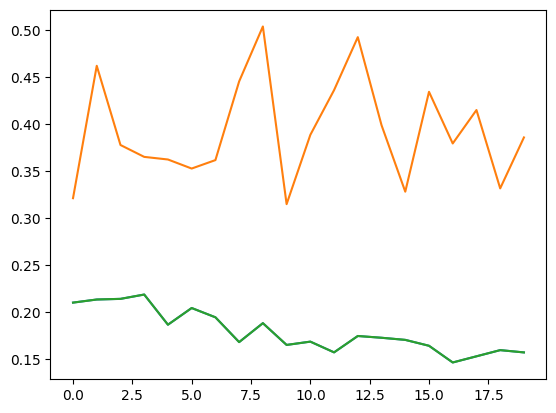

In [ ]:
# Comparing accuracy and loss curves for training and validation sets for feature extraction and fine-tuning
loss_fn = model_hisotry_fine.history['loss']
val_loss_fn = model_hisotry_fine.history['val_loss']
accuracy_fn = model_hisotry_fine.history['accuracy']
val_accuracy_fn = model_hisotry_fine.history['val_accuracy']

loss_fe = model_history.history['loss']
val_loss_fe = model_history.history['val_loss']
accuracy_fe = model_history.history['accuracy']
val_accuracy_fe = model_history.history['val_accuracy']

epochs = range(len(model_hisotry_fine.history['loss']))

# Plot loss
plt.figure()
plt.plot(epochs, loss_fn, label='training loss - fine-tuning')
plt.plot(epochs, val_loss_fn, label='val loss - fine-tuning')
plt.plot(epochs, loss_fn, label='training loss - feature extraction')
plt.plot(epochs, val_loss_fe, label='val loss - feature extraction')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend();

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy_fn, label='training_accuracy - fine-tuning')
plt.plot(epochs, val_accuracy_fn, label='val_accuracy - fine-tuning')
plt.plot(epochs, accuracy_fe, label='training_accuracy - feature extraction')
plt.plot(epochs, val_accuracy_fe, label='val_accuracy - feature extraction')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

## EVALUATION ON TEST DATA

In [ ]:
print("Evaluation on Test data \n")
loss, accuracy = model.evaluate(test_ds, batch_size=batch_size)
print(f"\nModel loss on test set: {(loss):.2f}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

Evaluation on Test data 



ValueError: You must call `compile()` before using the model.

## CONFUSION MATRIX

In [ ]:
class_names =  info.features["label"].names

pred = model.predict(test_ds)

y_pred = [pred[i].argmax() for i in range(len(pred))]
y_pred_class = [class_names[y_pred[i]] for i in range(len(y_pred))]

# Extract the truth ground label and match to class_names
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true_class = [class_names[y_true[i]] for i in range(len(y_true))]

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


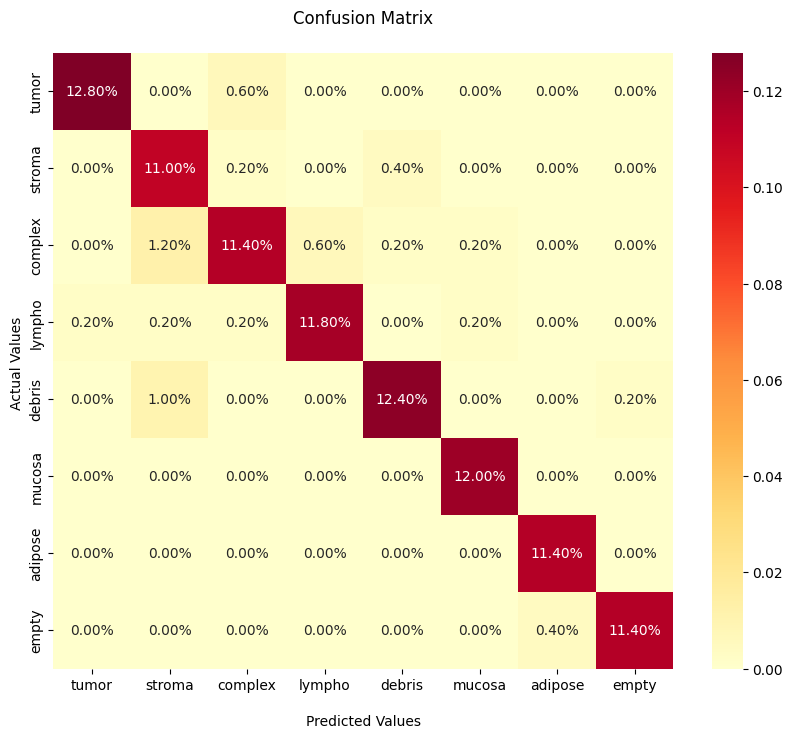

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='YlOrRd')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.show()

## CLASSFICATION REPORT

In [ ]:
print(classification_report(y_true_class, y_pred_class, digits=3))

              precision    recall  f1-score   support

     adipose      0.966     1.000     0.983        57
     complex      0.919     0.838     0.877        68
      debris      0.954     0.912     0.932        68
       empty      0.983     0.966     0.974        59
      lympho      0.952     0.937     0.944        63
      mucosa      0.968     1.000     0.984        60
      stroma      0.821     0.948     0.880        58
       tumor      0.985     0.955     0.970        67

    accuracy                          0.942       500
   macro avg      0.943     0.945     0.943       500
weighted avg      0.944     0.942     0.942       500

